In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import scipy.io as sci

import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

from sklearn.model_selection import train_test_split
from functools import partial

### Files

In [2]:
colab = False
if colab:
    from google.colab import drive
    drive.mount('/content/drive')
    path = '/content/drive/MyDrive/'
else:
    path = './'

In [3]:
Y_file = sci.loadmat(path + 'jasperRidge2_R198.mat')
Y = Y_file['Y'].astype(float)

gt_file = sci.loadmat(path + 'end4.mat')
E = gt_file['M']

A_gt = gt_file['A']

r_channels = 4
p = 198
n, m = 100, 100

Y.shape, E.shape, A_gt.shape

((198, 10000), (198, 4), (4, 10000))

### Tensors

In [4]:
A_gt_tensor = torch.tensor(A_gt, dtype=torch.float32).reshape([r_channels,n,m])
E_tensor = torch.tensor(E, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
A_gt_tensor.shape, E_tensor.shape, Y_tensor.shape

(torch.Size([4, 100, 100]), torch.Size([198, 4]), torch.Size([198, 10000]))

In [5]:
criterion = nn.MSELoss()
loss = criterion(torch.mm(E_tensor, A_gt_tensor.view(r_channels, n*m)), Y_tensor/Y_tensor.max())
loss

tensor(0.0022)

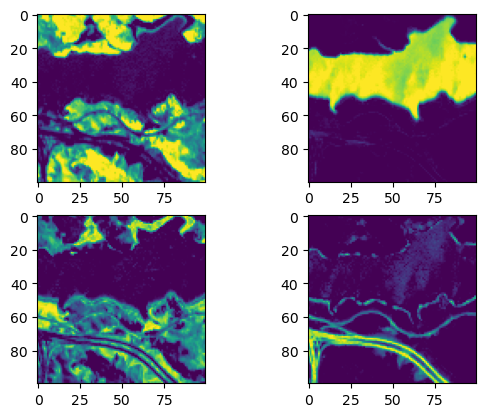

In [6]:
for i in range(4): 
    ax = plt.subplot(2, 2, i+1)
    ax.imshow(A_gt_tensor[i,:,:])

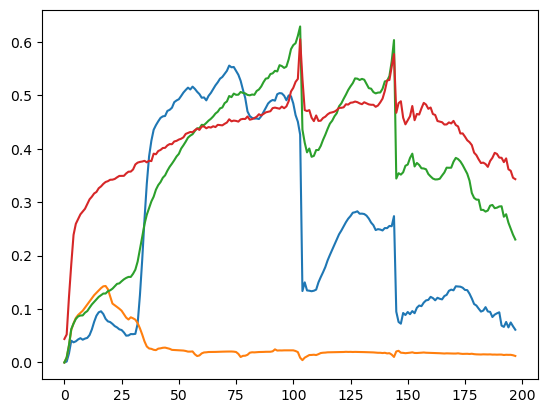

In [7]:
plt.plot(E_tensor)

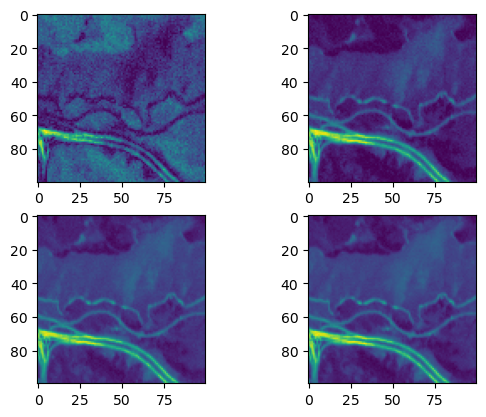

In [8]:
# Y
for i in range(4): 
    ax = plt.subplot(2, 2, i+1)
    ax.imshow(Y_tensor.reshape(198,100,100)[i,:,:])

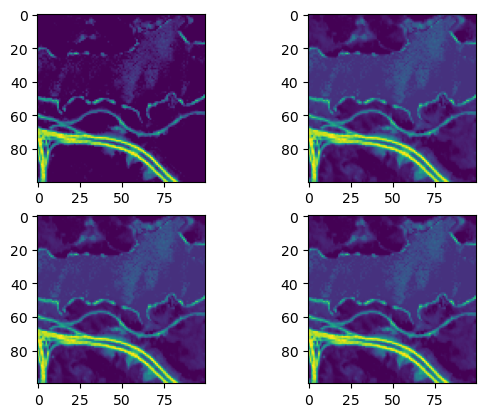

In [9]:
# E@A
for i in range(4): 
    ax = plt.subplot(2, 2, i+1)
    ax.imshow(torch.mm(E_tensor, A_gt_tensor.view(r_channels, n*m)).reshape(198,100,100)[i,:,:])

### Model

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'


encoder_channels = [256,256]
decoder_channels = [256,256,r_channels]
skip_channels = 4

# Define the network architecture
class Undip_net_paper(nn.Module):
  def __init__(self):
    super(Undip_net_paper, self).__init__()
    
    self.encoder1 = nn.Sequential(nn.Conv2d(r_channels, encoder_channels[0], (3, 3), 
                                            stride=(2, 2), padding_mode='reflect', padding=1, dilation=1), # (308,308) to (154,154)
                                  nn.BatchNorm2d(encoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), 
    )
    
    self.encoder2 = nn.Sequential(nn.Conv2d(encoder_channels[0], encoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(encoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (154,154)
    )

    self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')


    self.skip = nn.Sequential(nn.Conv2d(r_channels, skip_channels, (1, 1), stride=(1, 1), 
                                        padding=0, dilation=1),
                              nn.BatchNorm2d(skip_channels),
                              nn.LeakyReLU(inplace=True, negative_slope=0.1),
    )
    
    
    
    self.decoder1 = nn.Sequential(nn.BatchNorm2d(encoder_channels[1]+skip_channels),
                                  nn.Conv2d(encoder_channels[1]+skip_channels, decoder_channels[0],
                                            (3, 3), stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[0]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1)
    )


   
    self.decoder2 = nn.Sequential(nn.Conv2d(decoder_channels[0], decoder_channels[1], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.BatchNorm2d(decoder_channels[1]),
                                  nn.LeakyReLU(inplace=True, negative_slope=0.1), # (77,77)
    )

    self.decoder3 = nn.Sequential(nn.Conv2d(decoder_channels[1], decoder_channels[2], (3, 3), 
                                            stride=(1, 1), padding_mode='reflect', padding=1, dilation=1),
                                  nn.Softmax(dim=1)
    )


  def forward(self, input):
    
        
    current_feature = self.encoder1(input)
    current_feature = self.encoder2(current_feature)
    current_feature = self.upsample(current_feature)
    
    current_skip_output = self.skip(input)

    current_feature = torch.cat((current_feature,current_skip_output), dim=1)
    
    
    current_feature = self.decoder1(current_feature)
    current_feature = self.decoder2(current_feature)
    output = self.decoder3(current_feature)
    
      
    return output



def train(model, input, E_tensor, Y_tensor, epochs=2000, lr=0.01):
  
  
  optimizer = optim.Adam(model.parameters(), lr=lr)
  criterion = nn.MSELoss()

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



  model = model.to(device)
  input = input.to(device)
  criterion = criterion.to(device)
  E_tensor = E_tensor.to(device)
  Y_tensor = Y_tensor.to(device)


  losses = []
  outputs = torch.zeros([epochs, 1, r_channels, n, m])
  model.eval() if optimizer is None else model.train()
  for epoch in range(1, epochs + 1):
    model.train()
    train_loss = 0.0
    
    optimizer.zero_grad()
    
    output = model(input)

    #loss = criterion(output.reshape(-1,r_channels)@end_member_estimation, gt_fractional_abundance)
    loss = criterion(torch.mm(E_tensor, output.view(r_channels, n*m)), Y_tensor)
    #loss = criterion(output, gt_fractional_abundance)

    print('Epoch {}: '.format(epoch), loss.item())
    losses.append(loss.item())
    outputs[epoch-1] = output.detach()
    
    loss.backward()
    optimizer.step()

  return outputs, losses



### Training

In [11]:
A = torch.normal(0,1,size=(1,r_channels,n,m), dtype=torch.float32)

In [22]:
Undip_model = Undip_net_paper()
# the training command
outputs, losses = train(Undip_model,A, E_tensor, Y_tensor/Y_tensor.max(), lr=0.001, epochs=100)

Epoch 1:  0.03298354521393776
Epoch 2:  0.01984308660030365
Epoch 3:  0.017838357016444206
Epoch 4:  0.016110733151435852
Epoch 5:  0.007850541733205318
Epoch 6:  0.0076866596937179565
Epoch 7:  0.004894571378827095
Epoch 8:  0.004163528326898813
Epoch 9:  0.0041058906354010105
Epoch 10:  0.003653594059869647
Epoch 11:  0.0031672269105911255
Epoch 12:  0.0028439457528293133
Epoch 13:  0.002672853646799922
Epoch 14:  0.002595255384221673
Epoch 15:  0.002515861764550209
Epoch 16:  0.002394533483311534
Epoch 17:  0.0022646263241767883
Epoch 18:  0.002181215677410364
Epoch 19:  0.0021582525223493576
Epoch 20:  0.0021477672271430492
Epoch 21:  0.002105990657582879
Epoch 22:  0.0020376648753881454
Epoch 23:  0.0019571958109736443
Epoch 24:  0.0018836690578609705
Epoch 25:  0.0018283022800460458
Epoch 26:  0.0017911357572302222
Epoch 27:  0.001764966524206102
Epoch 28:  0.0017360241618007421
Epoch 29:  0.0017101288540288806
Epoch 30:  0.0016889828257262707
Epoch 31:  0.001667182194069028
Epoc

In [23]:
A_ = outputs[-1]

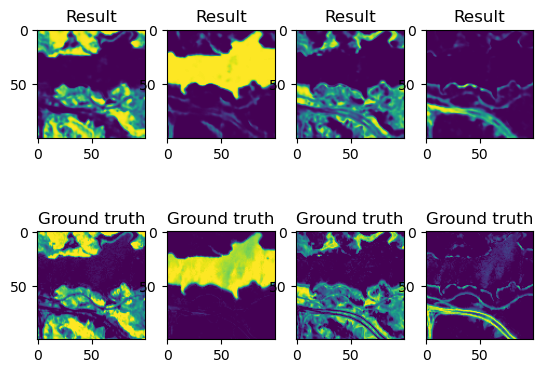

In [24]:
for i in range(4): 
    ax = plt.subplot(2, 4, i+1)
    im = A_
    im = im[0, i,:,:]
    ax.imshow(im)
    plt.title('Result')

for i in range(4): 
      ax = plt.subplot(2, 4, i+5)
      im = A_gt_tensor.view([1,r_channels,n,m])
      im = im[0,i,:,:]
      ax.imshow(im)
      plt.title('Ground truth')

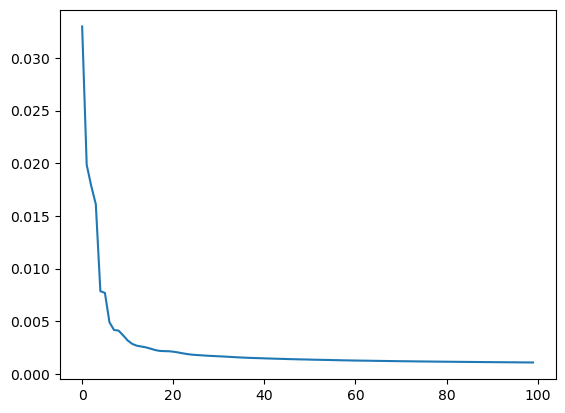

In [25]:
plt.plot(losses)

### Ecart avec groud truth

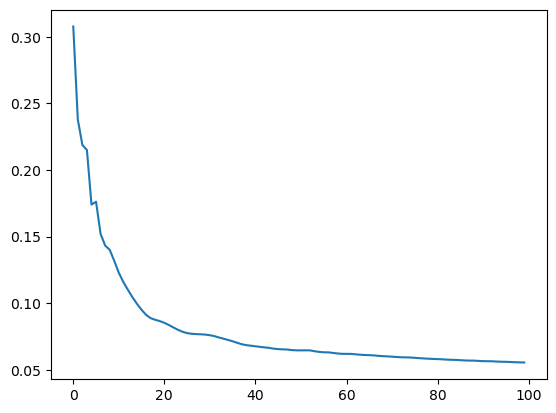

In [26]:
ecarts = []
for k in range(100):
  ecarts.append(nn.L1Loss()(outputs[k], A_gt_tensor.view([1,r_channels,n,m])))

plt.plot(ecarts)